In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tira.rest_api_client import Client
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import re

In [2]:
tira = Client()
   
    # loading train data
text_train = tira.pd.inputs(
        "nlpbuw-fsu-sose-24", "language-identification-train-20240429-training"
)
targets_train = tira.pd.truths(
        "nlpbuw-fsu-sose-24", "language-identification-train-20240429-training"
)
 # loading validation data (automatically replaced by test data when run on tira)
text_validation = tira.pd.inputs(
        "nlpbuw-fsu-sose-24", "language-identification-validation-20240429-training"
)
targets_validation = tira.pd.truths(
        "nlpbuw-fsu-sose-24", "language-identification-validation-20240429-training"
)

### Separate Latin from Non-Latin

In [3]:
latin = ['af', 'az', 'cs', 'da', 'de', 'en', 'es', 'fi', 'fr', 'hr', 'it', 'nl', 'no', 'pl'] # '0041-024F'
latin_label = np.isin(targets_train['lang'], latin)
df = pd.DataFrame(latin_label, columns=["latin"])
targets_train_latin_labeled = pd.concat([targets_train, df] , axis =1)
targets_train_latin_only = targets_train_latin_labeled.drop(targets_train_latin_labeled[targets_train_latin_labeled.latin == False].index)
print(targets_train_latin_only)

text_train_latin_labeled = pd.concat([text_train, df] , axis =1)
text_train_latin_only = text_train_latin_labeled.drop(text_train_latin_labeled[text_train_latin_labeled.latin == False].index)

# same for validation dataset
latin_label_val = np.isin(targets_validation['lang'], latin)
df2 = pd.DataFrame(latin_label_val, columns=["latin"])
targets_val_latin_labeled = pd.concat([targets_validation, df2] , axis =1)
targets_val_latin_only = targets_val_latin_labeled.drop(targets_val_latin_labeled[targets_val_latin_labeled.latin == False].index)
text_val_latin_labeled = pd.concat([text_validation, df2] , axis =1)
text_val_latin_only = text_val_latin_labeled.drop(text_val_latin_labeled[text_val_latin_labeled.latin == False].index)
print(text_val_latin_only)

            id lang  latin
0            1   de   True
2            3   da   True
3            4   de   True
5            6   az   True
9           10   fi   True
...        ...  ...    ...
319994  399993   es   True
319995  399994   cs   True
319996  399995   hr   True
319997  399996   az   True
319998  399998   it   True

[224000 rows x 3 columns]
           id                                               text  latin
0          14  Suzanna, la rivale de Candy, est morte de mala...   True
1          26  W wyniku agresji radzieckiej na Polskę 17 wrze...   True
3          52  Azilal (berbisk : ⴰⵣⵉⵍⴰⵍ) er en provins i den ...   True
4          63  Nalazi se na 46° 7' sjeverne zemljopisne širin...   True
5          65  Na standardnim registarskim pločicama sva slov...   True
...       ...                                                ...    ...
39993  399936  Mientras estaba exiliado en Rabat (Marruecos) ...   True
39996  399960  Državni rezervat prirode Shennongjia (神农架国家自然保...   True
3

### Convert languages to IDs

In [4]:
#targets_train_encoded = LabelEncoder().fit_transform(targets_train_latin_only["lang"])
#targets_val_encoded = LabelEncoder().fit_transform(targets_val_latin_only["lang"])
#print(targets_train_encoded[:10])
#print(len(np.unique(targets_train_encoded))) #14 latin languages in dataset

### Remove Punctation and Numbers and convert to lower case.

In [4]:
remove_punctuation = str.maketrans('', '', r"-()\"#/@;:<>{}-=~|.?,")

def PunctFreeLower(texts):
    cleaned = []
    for text in texts:
        # punctation gets replaced by space and 
        # all letters are converted to lower case
        cleaned.append((re.sub(r"[0-9]+", "", (text.translate(remove_punctuation)))).lower())
    return cleaned

In [5]:
text_train_cleaned = PunctFreeLower(text_train_latin_only["text"])
text_val_cleaned = PunctFreeLower(text_val_latin_only["text"])
print(text_val_cleaned[:5])

["suzanna la rivale de candy est morte de maladie elle n'a jamais été mariée à terry bien qu'il se soit occupé d'elle jusqu'au bout ce dernier après un longue période de deuil écrit à candy pour lui faire part de ses sentiments qui n'ont pas changé ", 'w wyniku agresji radzieckiej na polskę  września  do białoruskiej srr przyłączono wschodnią część mazowsza część podlasia polesia i grodno w latach – białoruś była okupowana przez wojska niemieckie w okresie ii wojny światowej kilka milionów białorusinów walczyło w armii czerwonej w tym ok  tys – w partyzantce próby tworzenia struktur państwowych pod patronatem niemieckim nie znalazły szerszego poparcia niemcy wymordowali bardzo licznych na białorusi żydów a także co najmniej  tys białoruskiej ludności cywilnej po zakończeniu wojny znaczna część polaków została wysiedlona w nowe granice polski łączne straty wojenne białorusi należą do największych w europie  mln zabitych i zamordowanych ok % ludności kraj poniósł także duże straty w mają

In [7]:
#vec = CountVectorizer(max_features=8000)
#text_train_vec = vec.fit_transform(text_train_cleaned)
#text_val_vec = vec.transform(text_val_cleaned)

vec2 = CountVectorizer(analyzer='char', ngram_range=(1, 3))
text_train_vec2 = vec2.fit_transform(text_train_cleaned)
text_val_vec2 = vec2.transform(text_val_cleaned)

print(text_train_vec2[:4])


  (0, 18534)	23
  (0, 21024)	52
  (0, 50469)	27
  (0, 0)	52
  (0, 23973)	5
  (0, 36718)	20
  (0, 59101)	11
  (0, 25535)	10
  (0, 27468)	13
  (0, 11443)	24
  (0, 41947)	46
  (0, 14800)	17
  (0, 29638)	12
  (0, 61582)	5
  (0, 79721)	2
  (0, 56406)	17
  (0, 67506)	3
  (0, 63332)	5
  (0, 47726)	3
  (0, 53629)	8
  (0, 16819)	5
  (0, 72484)	5
  (0, 39503)	4
  (0, 34384)	2
  (0, 77989)	1
  :	:
  (3, 49775)	1
  (3, 12268)	1
  (3, 24775)	1
  (3, 49795)	1
  (3, 13715)	1
  (3, 67539)	1
  (3, 59120)	1
  (3, 1020)	1
  (3, 31271)	1
  (3, 51375)	1
  (3, 31957)	1
  (3, 59133)	1
  (3, 19039)	1
  (3, 22046)	1
  (3, 46396)	1
  (3, 13346)	1
  (3, 57222)	1
  (3, 31560)	1
  (3, 61593)	1
  (3, 35071)	1
  (3, 29660)	1
  (3, 15182)	1
  (3, 21595)	1
  (3, 18417)	1
  (3, 51350)	1


In [8]:
print(text_train_vec2.shape)
print(text_val_vec2.shape)
print(vec2.get_feature_names_out())

(224000, 126316)
(28000, 126316)
[' ' ' !' ' ! ' ... '𒌷𒀔 ' '𒌷𒀕' '𒌷𒀕 ']


### Fit Bernoulli Naive Bayes

In [9]:
bernoulli = BernoulliNB()
multinomial = MultinomialNB()
bernoulli.fit(text_train_vec2, targets_train_latin_only["lang"])
multinomial.fit(text_train_vec2, targets_train_latin_only["lang"])

MultinomialNB()

Accuracy is 99.7%
F1-score is 99.74286259354604%


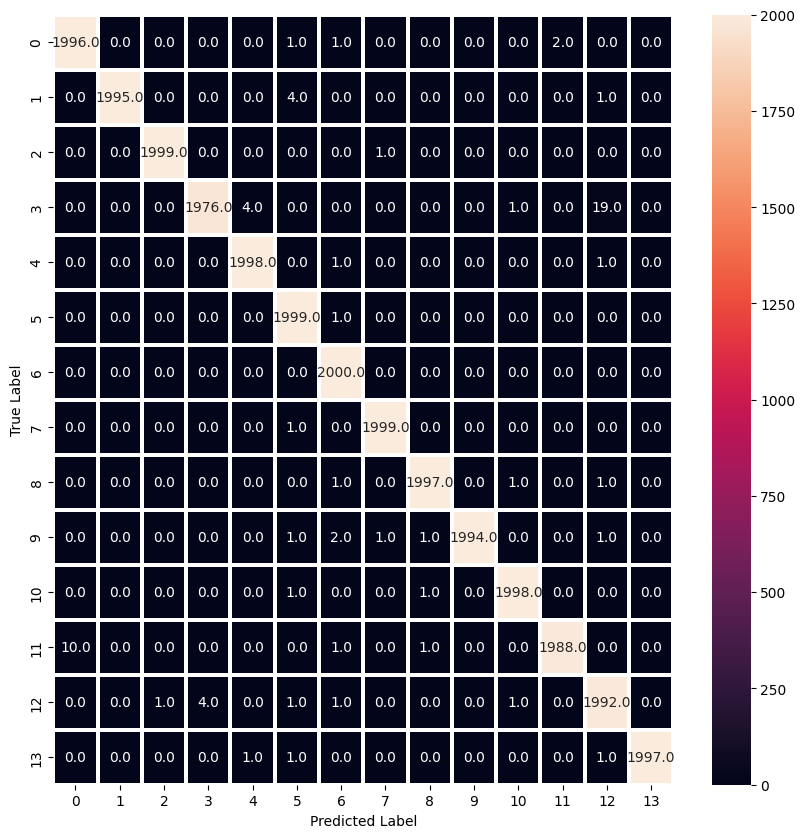

In [10]:
def eval(model, texts, targets):
    y_pred = model.predict(texts)
    conf_matrix = confusion_matrix(y_pred=y_pred,y_true=targets)
    acc = round(accuracy_score(y_pred=y_pred,y_true=targets),3) * 100
    f1 = f1_score(y_pred=y_pred, y_true=targets, average="weighted")*100
    
    print(f"Accuracy is {acc}%")
    print(f"F1-score is {f1}%")
    plt.subplots(figsize=(10,10))
    sns.heatmap(conf_matrix,annot=True,fmt=".1f",linewidths=1.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

eval(bernoulli, text_val_vec2, targets_val_latin_only["lang"])

Accuracy is 99.8%
F1-score is 99.75717720885471%


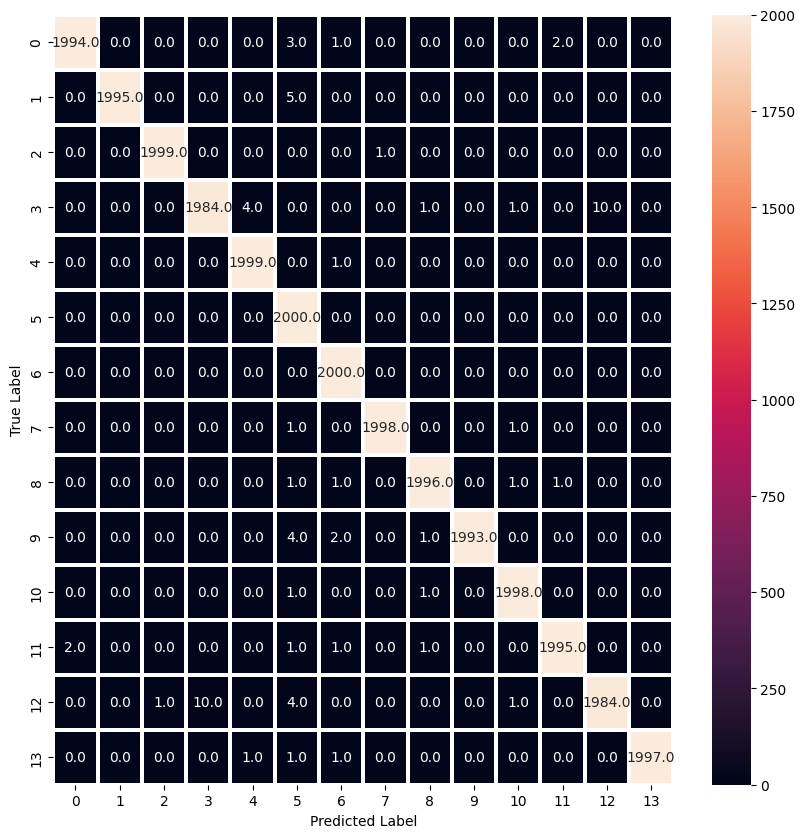

In [11]:
eval(multinomial, text_val_vec2, targets_val_latin_only["lang"])